In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# CSE: scipy.ndimage and scikit-image

<img src="files/img_proc_stack.svg"/>

- [ndimage docs](http://docs.scipy.org/doc/scipy/reference/ndimage.html)

In [2]:
from scipy import ndimage as ndi
ndi?

## Counting grains and bubbles

This Scanning Element Microscopy image shows a glass sample
(light gray matrix) with some bubbles (black) and unmolten
sand grains (dark gray). We wish to determine the fraction
of the sample covered by these three phases,
and to estimate the number of sand grains and bubbles,
their average sizes, etc.

### Loading the slide

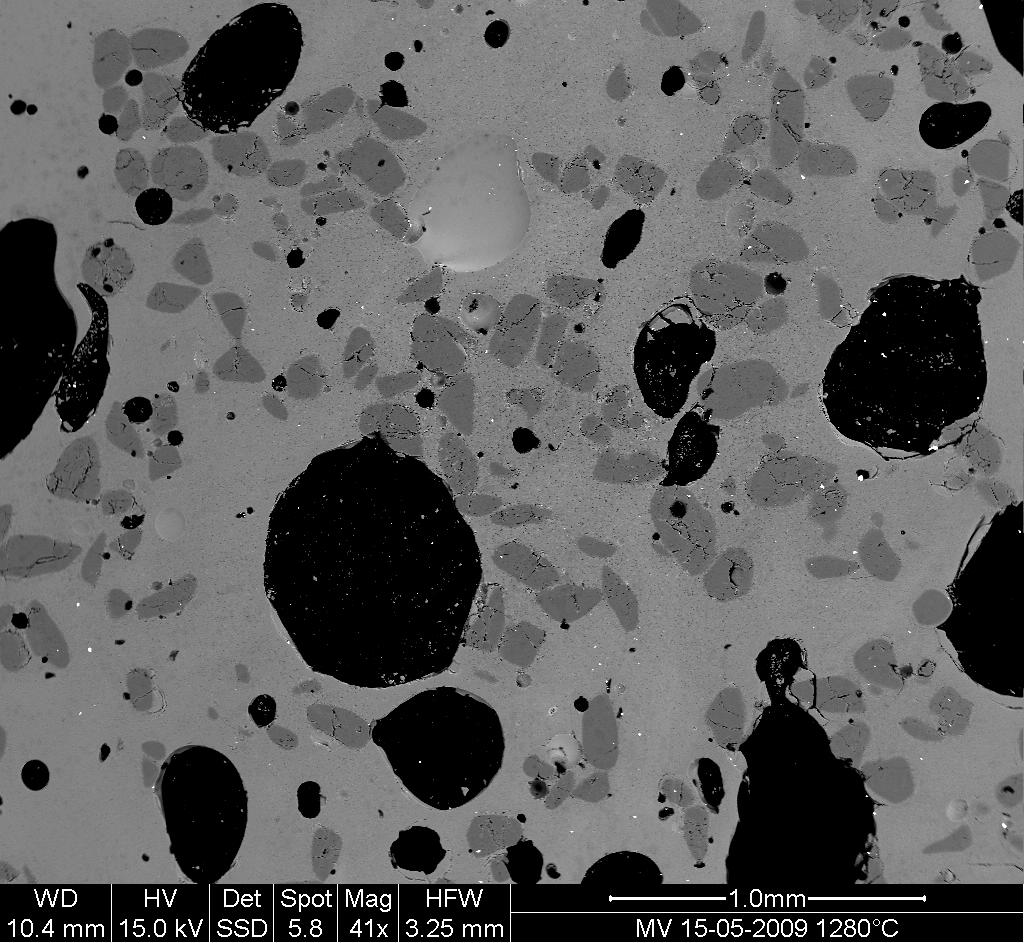

In [3]:
from IPython.display import Image
Image( 'bubbles.jpg')

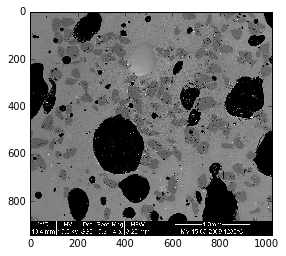

In [4]:
#img = np.flipud(plt.imread('bubbles.jpg'))
img = plt.imread('bubbles.jpg')
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest');

### Remove banner

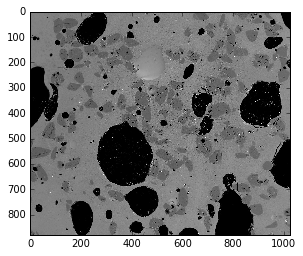

In [5]:
img_clean = img[:880, :]
plt.imshow(img_clean, cmap=plt.cm.gray, interpolation='nearest');

### Filter to get rid of speckles

Note matplotlib default colormap and interpolation:

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


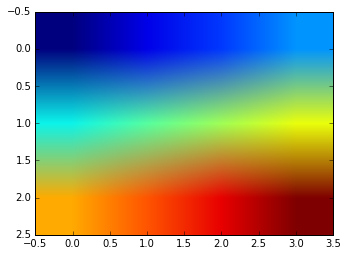

In [6]:
import numpy as np
x = np.arange(12).reshape((3, 4))
print(x)
plt.imshow(x);

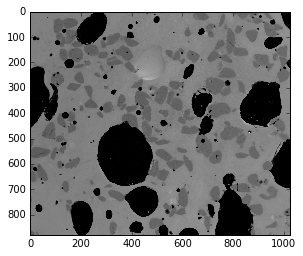

In [7]:
import scipy.ndimage as ndi
img_med = ndi.median_filter(img_clean, size=5)
plt.imshow(img_med, cmap=plt.cm.gray, interpolation='nearest');

### Find threshold values

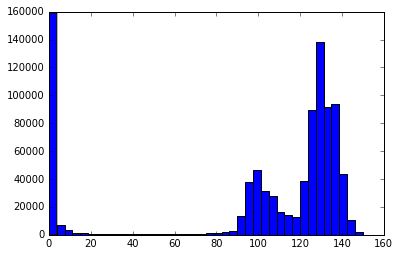

In [8]:
plt.hist(img_med.flatten(), bins=40, range=(0, 150));

### Separate layers by thresholding

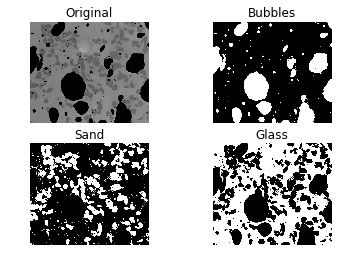

In [9]:
bubbles = (img_med <= 50)
sand = (img_med > 50) & (img_med <= 120)
glass = (img_med > 120)

def plot_images(cmap=plt.cm.gray):
    for n, (name, image) in \
        enumerate([('Original', img_med),
                   ('Bubbles', bubbles),
                   ('Sand', sand),
                   ('Glass', glass)]):
    
        plt.subplot(2, 2, n + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(name)
        plt.axis('off')
        
plot_images();

### Visualise layers

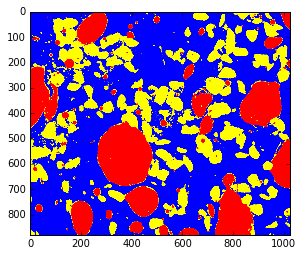

In [10]:
def plot_color_overlay():
    all_layers = np.zeros((img_clean.shape[0],
                           img_clean.shape[1], 3)) # Color image

    # You shouldn't run this if bubbles isn't a mask
    # -- otherwise, fancy indexing instead of masking
    assert(bubbles.dtype == np.bool)
    
    all_layers[bubbles] = (1, 0, 0)
    all_layers[sand] = (1, 1, 0)
    all_layers[glass] = (0, 0, 1)

    plt.imshow(all_layers)

plot_color_overlay()

### Clean up shapes found

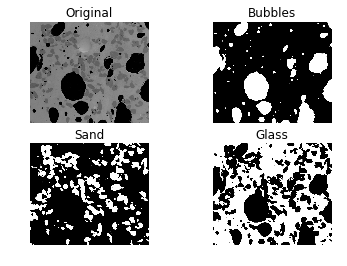

In [11]:
for img in (sand, bubbles, glass):
    img[:] = ndi.binary_opening(img, np.ones((5, 5)))
    img[:] = ndi.binary_closing(img, np.ones((5, 5)))
    
plot_images()

### Label connected components

115 regions found in Sand
Mean obj area 1769
70 regions found in Bubbles
Mean obj area 2516
27 regions found in Glass
Mean obj area 19111


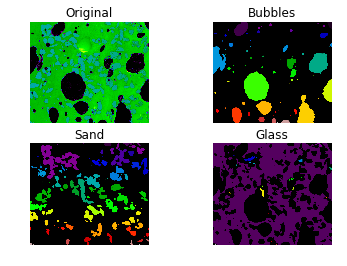

In [12]:
# Convert to int so we can store the labels
bubbles = bubbles.astype(int)
sand = sand.astype(int)
glass = glass.astype(int)

for name, img in [('Sand', sand),
                  ('Bubbles', bubbles),
                  ('Glass', glass)]:
    labels, count = ndi.label(img)
    print('%s regions found in %s' % (count, name))
    img[:] = labels
    
    obj_areas = [np.sum(labels == i) for \
                 i in range(1, labels.max())]
    print("Mean obj area %d" % np.mean(obj_areas))

plot_images(cmap=plt.cm.spectral)

<img src="files/skimage_logo.png" style="float: left;"/>
<div style="clear: both;">

- [Homepage](http://skimage.org)
- [Documentation](http://scikits-image.org/docs/dev/)
- [Gallery](http://scikits-image.org/docs/dev/auto_examples/index.html)

### Gallery example

In [ ]:
%load http://scikit-image.org/docs/dev/_downloads/plot_equalize.py

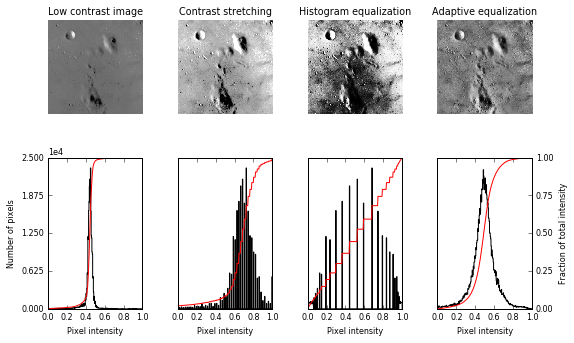

In [14]:
"""
======================
Histogram Equalization
======================

This examples enhances an image with low contrast, using a method called
*histogram equalization*, which "spreads out the most frequent intensity
values" in an image [1]_. The equalized image has a roughly linear cumulative
distribution function.

While histogram equalization has the advantage that it requires no parameters,
it sometimes yields unnatural looking images.  An alternative method is
*contrast stretching*, where the image is rescaled to include all intensities
that fall within the 2nd and 98th percentiles [2]_.

.. [1] http://en.wikipedia.org/wiki/Histogram_equalization
.. [2] http://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm

"""

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()


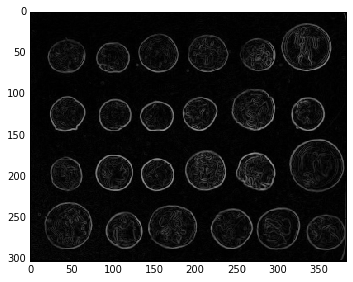

In [2]:
from skimage import data, filters, io

image = data.coins()
edges = filters.sobel(image)
io.imshow(edges)

Note: these are simply numpy arrays, hence you can also do:

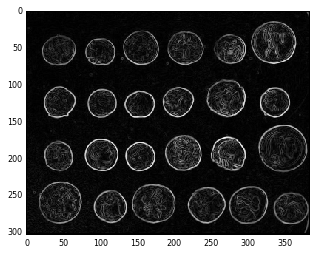

In [16]:
import matplotlib.pyplot as plt
plt.imshow(edges, cmap=plt.cm.gray, interpolation='nearest');

### File input/output

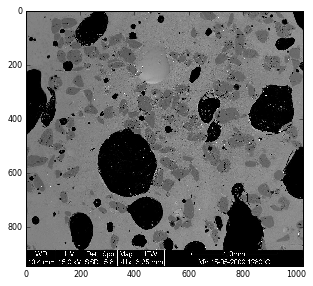

In [17]:
from skimage import io

img = io.imread('bubbles.jpg')
io.imshow(img)

In [85]:
io.imshow(img, fancy=True, plugin='qt')
io.show()

In [ ]:
io.use_plugin('matplotlib')
io.imshow(io.pop())

- Demo other interactive exploration widgets
- Show Jupyter widgets

### Install widgets as follows:

With pip:

```
pip install ipywidgets
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

With conda:

```
conda install -c conda-forge ipywidgets
```

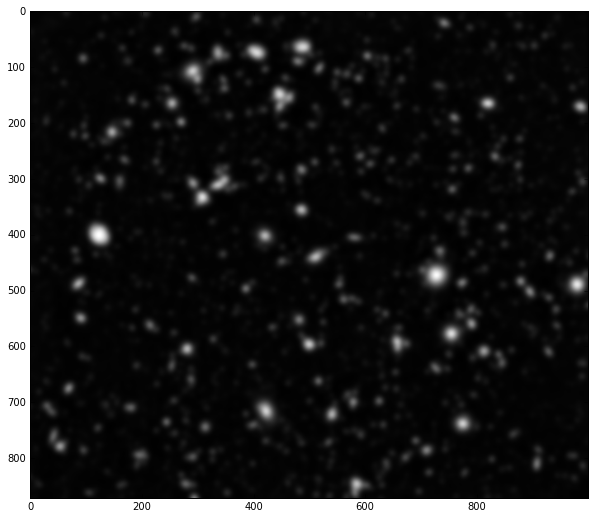

In [11]:
from ipywidgets import interact
from skimage import color

image = color.rgb2gray(data.hubble_deep_field())

@interact(sigma=(0.1, 10, 0.1))
def filter_image(sigma=1):
    f = plt.figure(figsize=(10, 10))
    plt.imshow(filters.gaussian(image, sigma=sigma), cmap='gray')

Before running this cell, you may have to `pip install pyfits`

In [ ]:
ngc7635 = io.imread('ngc7635_041008_15i75m_L.FIT', plugin='fits')
io.imshow(ngc7635)

If you cannot install fits, use the following instead:

In [ ]:
# from skimage import img_as_uint
# from skimage import color
#
# ngc7635 = img_as_uint(color.rgb2gray(data.hubble_deep_field()))
# 
# plt.imshow(ngc7635, cmap='gray')

### Data types and ranges

[Data-type documentation](http://scikits-image.org/docs/dev/user_guide/data_types.html)

In [ ]:
print(ngc7635.dtype)
print(ngc7635.min(), ngc7635.max())

In [ ]:
from skimage import filters
out = filters.gaussian(ngc7635, sigma=10)

plt.imshow(out, cmap='gray')

In [ ]:
from skimage import exposure
ngc7635_ = exposure.rescale_intensity(ngc7635, in_range=(0, 16000))
plt.imshow(ngc7635_, cmap='gray')

In [ ]:
# Conversion functions
from skimage import img_as_float, img_as_int, img_as_ubyte

print(img_as_float(ngc7635_).max())
print(img_as_int(ngc7635_).max())
print(img_as_ubyte(ngc7635_).max())

### Obtaining test data

In [ ]:
from skimage import data
io.imshow(data.camera());

In [ ]:
io.imshow(data.hubble_deep_field());

### Constructing a pipeline

In ``skimage``, functions should take any data-type image as input, but produce whichever data-type
output it can generate most efficiently.  This means that you can always build pipelines (i.e. apply an skimage function to the output of another):

In [ ]:
from skimage import feature, restoration

import toolz
from functools import partial

img = data.camera()

pipeline = toolz.compose(partial(feature.canny, sigma=5),
                         partial(restoration.denoise_tv_bregman, weight=1))

## This is identical to:
#
# def pipeline(image):
#    return feature.canny(restoration.denoise_tv_bregman(image, weight=1), sigma=5)

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
ax0.imshow(img, cmap='gray')
ax1.imshow(pipeline(img), cmap='gray')

### Shortest paths

See http://scikit-image.org/docs/dev/api/api.html

In [ ]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('6NcIJXTlugc')

### Color spaces

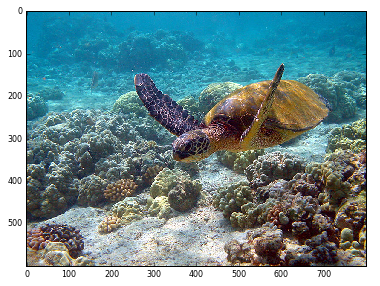

In [27]:
# Turtle image by Brocken Inaglory (http://commons.wikimedia.org/wiki/File:Hawaii_turtle_2.JPG)
img = io.imread('Hawaii_turtle.jpg')[..., :3]

# Explore HSV color space
io.imshow(img)

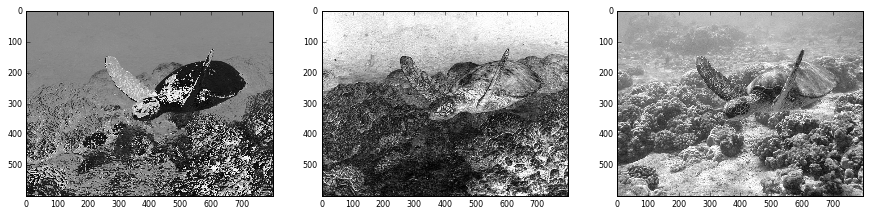

In [29]:
from skimage import color
hsv = color.rgb2hsv(img)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))
ax0.imshow(hsv[..., 0], cmap='gray')
ax1.imshow(hsv[..., 1], cmap='gray')
ax2.imshow(hsv[..., 2], cmap='gray')

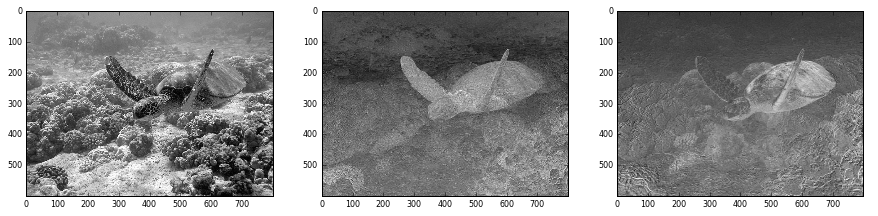

In [30]:
from skimage import color
lab = color.rgb2lab(img)

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))
ax0.imshow(lab[..., 0], cmap='gray')
ax1.imshow(lab[..., 1], cmap='gray')
ax2.imshow(lab[..., 2], cmap='gray')

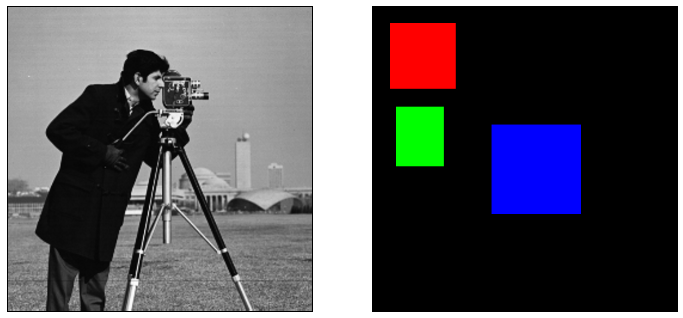

In [34]:
from skimage import data, io, img_as_float
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.6

img = img_as_float(data.camera())
rows, cols = img.shape

# Construct a colour image to superimpose
color_mask = np.zeros((rows, cols, 3))
color_mask[30:140, 30:140] = [1, 0, 0]  # Red block
color_mask[170:270, 40:120] = [0, 1, 0] # Green block
color_mask[200:350, 200:350] = [0, 0, 1] # Blue block

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(color_mask);

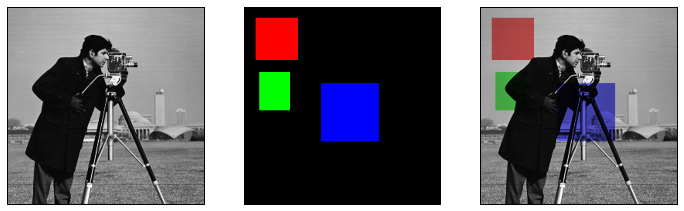

In [45]:
# Convert the input image and color mask to Hue Saturation Value (HSV)
# colorspace
from skimage import color
color_mask_hsv = color.rgb2hsv(color_mask)

# Construct RGB version of grey-level image
img_hsv = color.rgb2hsv(color.gray2rgb(img))

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

img_masked = color.hsv2rgb(img_hsv)

# Display the output
f, (ax0, ax1, ax2) = plt.subplots(1, 3,
                                  subplot_kw={'xticks': [], 'yticks': []},
                                  figsize=(12, 8))
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(color_mask)
ax2.imshow(img_masked)
plt.show()

### Geometric Transformations

In [54]:
transform.AffineTransform?

Let's send a coordinate through the transformation by hand:
Origin maps to -> [[ 150.    0.]]


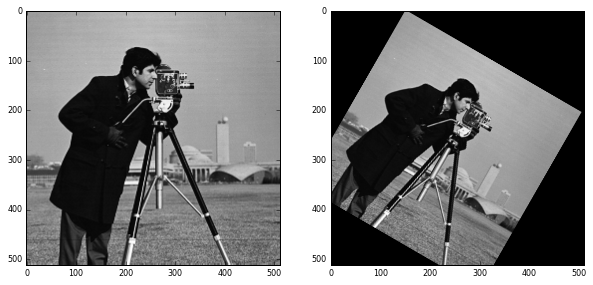

In [59]:
from skimage import transform

img = data.camera()

theta = np.deg2rad(30)
s = 0.8
tx, ty = 150, 0

tf = transform.AffineTransform(scale=(s, s), rotation=theta, shear=None, translation=(tx, ty))

img = data.camera()
out = transform.warp(img, tf.inverse)

print("Let's send a coordinate through the transformation by hand:")
print("Origin maps to ->", tf([0, 0]))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(img, cmap=plt.cm.gray)
ax1.imshow(out, cmap=plt.cm.gray);

### Non-linear warping

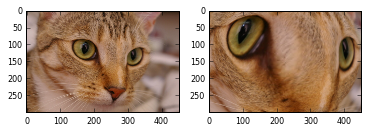

In [70]:
from skimage import transform

image = data.chelsea()

def fisheye(xy):
    center = np.mean(xy, axis=0)
    xc, yc = (xy - center).T
    
    # Polar coordinates
    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)

    r = 0.95 * np.exp(r**(1/2.3) / 2.1)

    return np.column_stack((
        r * np.cos(theta), r * np.sin(theta)
        )) + center 

out = transform.warp(image, fisheye)

f, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax1.imshow(out);

### Stand-alone demos: Canny + Hough visualizers

### Block views and filtering

In [71]:
from skimage.util.shape import view_as_windows
img = data.camera()
img.shape

(512, 512)

In [72]:
w = view_as_windows(img, window_shape=(20, 20))
print(w.shape)

(493, 493, 20, 20)


In [73]:
img_max = w.max(axis=2).max(axis=2)
print(img_max.shape)

(493, 493)


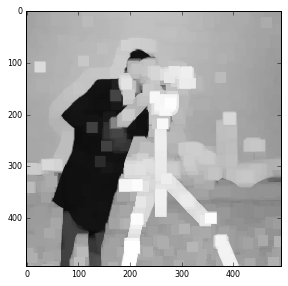

In [74]:
io.imshow(img_max)

The same can now be achieved using Dask: [demo](dask_ghosting.ipynb)

### Histogram of gradients

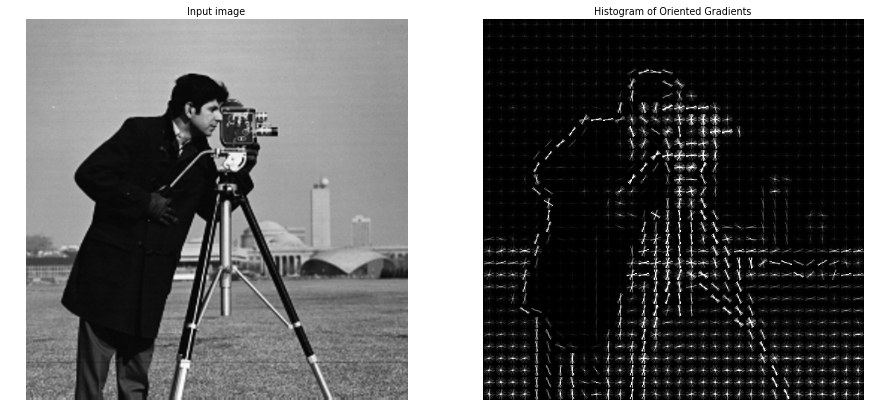

In [84]:
from skimage.feature import hog
from skimage import data, color, exposure

image = data.camera()

fd, hog_image = hog(image, orientations=16, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display results side-by-side

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))

ax0.set_axis_off()
ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title('Input image')

ax1.set_axis_off()
ax1.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax1.set_title('Histogram of Oriented Gradients')

plt.show()

# Breakout

Please pick one of the following problems to work on.

## Image registration

Consider two satellite views of the same area:

<pre>
webreg_0.jpg webreg_1.jpg
</pre>

1. Load and display the images.
2. Find coordinates that correspond between these images.  The easiest way
   is probably outside the notebook, using `plt.ginput`.
3. Using these sets of corresponding coordinates, fit an affine transform:
   `skimage.transform.AffineTransform`.
4. Apply the transform and then combine the two images.

Hints:

 - Look at ``skimage.transform``.
 - Use matplotlib's ``ginput`` to find point coordinates.

The process of aligning and combining images is known as "image registration".

For a much more detailed panoramic stitching example, see

https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb


## False-color image representation

Consider the provided image files:

<pre>
  m8_050507_26i26m_L.png  m8_050507_9i9m_B.png  m8_050507_9i9m_R.png
  m8_050507_5i75m_H.png   m8_050507_9i9m_G.png
</pre>

1. Load and display the individual inputs
2. Add the inputs to form a single grey-level image
3. Now, combine these images into a single, color  image.  Apply denoising as
   as you see fit.  An example pipeline is given here:

  http://www.mistisoftware.com/astronomy/Process_m8.htm

Hints:

 - These images are enormous--scale them down before playing around.
 - It may sometimes be easier to manipulate image colors in the HSV domain
 - A colour image has dimensions ``(M, N, 3)`` for red, green and blue layers.


[RANSAC lecture and breakout](ransac.ipynb)